In [115]:
from cmdstanpy import CmdStanModel

from seaborn import jointplot
import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

/tmp/ipykernel_372/1651812090.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["Mean speed"] = train_df["Road distances [km]"] / (train_df["Time_taken(min)"] - train_df["Meal_preparation_time"]) * 60


count    4425.000000
mean       33.776533
std        22.483143
min         2.057143
25%        16.233913
50%        28.185000
75%        46.780000
max        99.960000
Name: Mean speed, dtype: float64

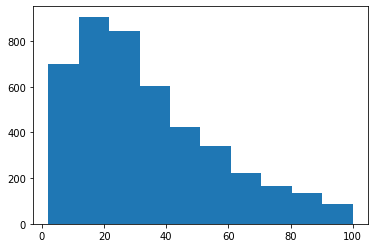

In [116]:
df = pd.read_csv('delivery_time_data.csv', delimiter=';', decimal=',')

df = df[df["Road distances [km]"] < 17.5]

# display(df.describe())

train_df = df.iloc[10000:15000, :]
train_df["Mean speed"] = train_df["Road distances [km]"] / (train_df["Time_taken(min)"] - train_df["Meal_preparation_time"]) * 60
train_df = train_df[train_df["Mean speed"] < 100]
plt.hist(train_df["Mean speed"])
train_df["Mean speed"].describe()

In [117]:
model_ppc=CmdStanModel(stan_file='basic_ppc.stan')

sim=model_ppc.sample(data={"N": len(train_df), "distance": train_df["Road distances [km]"].values,"meal_preparation_time": train_df["Meal_preparation_time"].values}, 
                     iter_sampling=1,
                     iter_warmup=0, 
                     chains=1, 
                     fixed_param=True,
                     seed=29042020)
prior_fit = sim.draws_pd()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


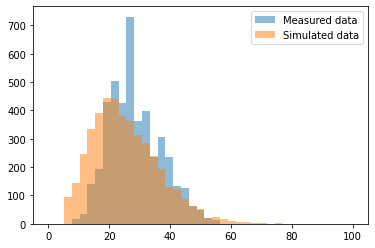

In [118]:
bins = np.linspace(0,100,40)
plt.hist(train_df["Time_taken(min)"], bins=bins, alpha=0.5, label="Measured data")
plt.hist(prior_fit.iloc[:, 3:].values.flatten(), bins=bins, alpha=0.5, label="Simulated data")
plt.legend()

In [119]:
print(len(prior_fit.iloc[:, 3:].values.flatten()))

print(len(train_df["Time_taken(min)"].values))



4425
4425


In [120]:
train_df["Approx time[min]"] = train_df["Road distances [km]"] / (50/60)

In [121]:
train_df["Approx time[min]"].describe()

count    4425.000000
mean       10.534571
std         5.488470
min         1.849200
25%         5.449200
50%        10.294800
75%        15.105600
max        20.990400
Name: Approx time[min], dtype: float64